# Plot the statistics of EF
LR grid

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
wichtr = 1;
ik = 1;

% ---- time
yr_s = 21;
[day_s, day_e, dt] = deal(1.0, 365*2, 1);  
t_al = day_s:dt:day_e;
nt_al = length(t_al);

% ---- grid
griddir = [workdir '/MOM6_exp/mom_lowRES/'];
[grid, ~, ~] = read_grid_MOM([griddir '']); % SOLUTION/
nk = length(grid.Layer);

% ---- dirs for eddy forcing
rootdir = [workdir '/MOM6_OUT/tr_off_64_180d'];
eforc_dir = [rootdir '/cforc_pt_prog_addreld10/']; 
varnm_eforc = 'cforc_rel#';
ncfile_preStr = 'forc__';

% ---- read
tr_al = {[workdir '/MOM6_OUT/tr_off_64_180d/sols_pt/tr_forcprog_addrel10d_ptrel/'], ...
         [workdir '/MOM6_OUT/tr_off_64/tr_pt_CS/']};
         ncel = numel(tr_al);

m_al = cell(1,ncel); m_al(:) = {zeros(1,nt_al)};
cf_al = cell(1,ncel); 
cfm_al = cell(1,ncel); 
cfstd_al = cell(1,ncel); 

for it = 1:nt_al
    [yrstr, dystr, hrstr] = get_timestr(t_al(it), yr_s); % for tend
    fnm = [eforc_dir ncfile_preStr yrstr '_' dystr '_' hrstr '.nc'];
    varnm = [varnm_eforc(1:end-1) num2str(wichtr)];
    cforc = ncread(fnm, varnm);
    cforc_al(:,:,it) = cforc(:,:,ik);
end
% time-mean and std
it_do = 30:nt_al; 
cforc_m   = mean(cforc_al(:,:,it_do), 3);
cforc_std = std(cforc_al(:,:,it_do), 0, 3);

% ---- read W_EF and truth tracer

c_al = cell(1,ncel); 
for it = 1:nt_al
    % current time
    t1 = t_al(it);
    [yrstr, dystr, hrstr] = get_timestr(t1, yr_s); % for k and tracer
    % read all runs
    for icel = 1:ncel
        c_fnm = [tr_al{icel} 'tr__' yrstr '_' dystr '_' hrstr '.nc'];
        % fnm
        c3d = ncread(c_fnm,'tr1');
        % [c] and [c*Vol]
        c_al{icel}(:,:,it) = c3d(:,:,ik);
    end
end

%----------------------- errors
icel_ref = ncel;
rms_RE_al = cell(1,ncel);  rms_RE_al(:) = {zeros(1,nt_al)};
rms_RE2_al = cell(1,ncel);  rms_RE2_al(:) = {zeros(1,nt_al)};
f_ref = c_al{icel_ref}; % xyzt-tr
for icel = 1:ncel
    f_do = c_al{icel};
    df = f_do - f_ref;
    re = df ./ f_ref;
    % operate over xy
    rms_RE_al{icel} = squeeze(rms(re, [1 2])); % domain rms
    rms_RE2_al{icel} = squeeze( rms(df, [1 2]) ./ rms(f_do, [1 2]) );
end

In [3]:
% -- save data
savefnm = [homedir '/work_MOM/data_for_figure/data_fig4.mat'];
save(savefnm,'cforc_al','cforc_m','cforc_std','rms_RE_al');

## get GS core

In [4]:
ds_GS = load('GScore_mom_unsm_wide.mat'); % GScore_mom_unsm or GScore_mom
x_GSC_m = ds_GS.x_GSC_m;
y_GSC_m = ds_GS.y_GSC_m;

# plot

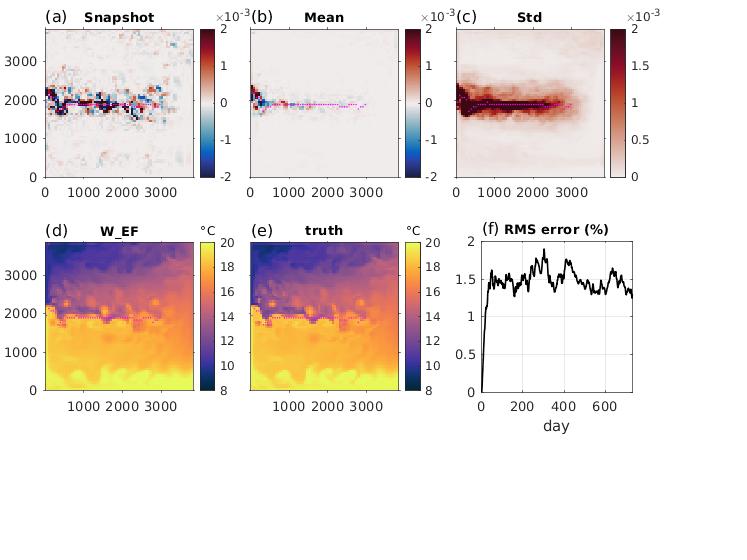

In [5]:
% load(savefnm)

it = 361;
f_plt = {cforc_al(:,:,it), cforc_m, cforc_std};
clim_al = {[-1 1]*2e-3, [-1 1]*2e-3, [0 1]*2e-3}; % 5e-4
titlstr = {'Snapshot', 'Mean', 'Std'};
cmp_al = {'balance', 'balance', 'amp'};
[x, y] = deal(grid.lonh, grid.lath);

% ---------
x_top = 0.06; y_top = 0.68; h_top = 0.27; w_top = h_top; dx_top = 0.005;
x_bot = 0.06; y_bot = 0.3; h_bot = h_top; w_bot = h_bot; dx_bot = dx_top;
% 
pos_top = { [x_top y_top w_top h_top], [x_top+w_top+dx_top y_top w_top h_top], [x_top+2*w_top+2*dx_top y_top w_top h_top]};
pos_bot = { [x_bot y_bot w_bot h_bot], [x_bot+w_bot+dx_bot y_bot w_bot h_bot], [x_bot+2*w_bot+2*dx_top y_bot w_bot h_bot]};

font = 'DejaVu Sans';
figure('DefaultTextFontName', font, 'DefaultAxesFontName', font);

for icel = 1:3
    subplot('Position',pos_top{icel});
    f_do = f_plt{icel};
    imagescn(x, y, f_do');
    axis square
    set(gca,'tickdir','out');
    caxis(clim_al{icel});
    cmocean(cmp_al{icel});
    title(titlstr{icel},'fontsize',10)
    cb = colorbar;
    xcb = cb.Position;
    % cb.Position = [xcb(1)+.035 xcb(2) xcb(3)*0.7 xcb(4)];

    if icel > 1; set(gca,'yticklabel',''); end
    hold on; scatter(x_GSC_m, y_GSC_m,8,'.m')
end

% ---------
clim = [8 20]; cmap = 'thermal';
titles = {'W\_EF', 'truth'};
for icel = 1:ncel
    % axes(ha(icel))
    subplot('Position',pos_bot{icel});
    
    f_do = c_al{icel}(:,:,it); 
    imagescn(x, y, f_do'); set(gca,'tickdir','out','xtick',[1e3:1e3:3e3]);
    cmocean('thermal'); axis square; caxis(clim)
    title(titles{icel},'fontsize',10)
    hold on; scatter(x_GSC_m, y_GSC_m,8,'.m')
    if icel >= 2; set(gca,'yticklabel',''); end
    % if icel == 1; set(gca,'yticklabel',{'11'}); end
    cb = colorbar;
    cb.Title.String = '\circC';
end

subplot('Position',pos_bot{3});
plot(t_al,rms_RE_al{1}*100, 'k', 'linewidth', 1.2)
axis square; 
set(gca,'XLim',[0 t_al(end)],'ylim',[0 2])
grid on
title('RMS error (%)','fontsize',10)
xlabel('day') 

hb = subplotlabel(gcf,'a','location','northwestoutside','offset',[-0.0 0.02],'Prefix','(','Postfix',')','fontsize',12);

% ---
set(gcf,'PaperPositionMode','auto'); 
fignm = [homedir '/work_MOM/figures/fig3_statsEF'];
% exportgraphics(gcf,[fignm '.pdf'], 'BackgroundColor','white','ContentType','vector')